In [ ]:
import init_close_connection
import pandas as pd
import seaborn as sns

#Retrive a dataframe only contain columns state and states fips
db_instance = init_close_connection.connection()
conn = db_instance.connect()
state_state_fips_df = pd.read_sql_query('SELECT DISTINCT STATE, STATE_FIPS from stormdata;', conn, index_col="STATE_FIPS")
conn.close()
state_state_fips_df = state_state_fips_df.sort_values(by="STATE_FIPS", ascending=True).drop(index=0, axis=0)
#Comment for Colton: Comment on the line of code below when you run your code
state_state_fips_df = state_state_fips_df.drop(labels = [48,20], axis = 0)

conn = db_instance.connect()
event_types_df = pd.read_sql_query('SELECT DISTINCT EVENT_TYPE from stormdata;', conn)
event_types_df = event_types_df.replace('/', ' or ', regex=True)
conn.close()

#This code is for generating the states dictionary for all the states data summaries
states = dict()
for fips in state_state_fips_df.index.values:
    table_name = state_state_fips_df.loc[fips]['STATE'] + ' DATA SUMMARY'
    conn = db_instance.connect()
    cur_df = pd.read_sql_query('SELECT * FROM `' + table_name + '`;', conn)
    cur_df['BEGIN_YEARMONTH'] = cur_df['BEGIN_YEARMONTH'].astype(str)
    states[state_state_fips_df.loc[fips]['STATE']] = cur_df
    conn.close()
init_close_connection.close_final_connection(db_instance)

#This code here below is for creating the table that contains the relevant attributes
relevant_attributes = pd.DataFrame()
for key, value in states.items():
    state_injuries_direct = 0
    state_injuries_indirect = 0
    state_deaths_direct = 0
    state_deaths_indirect = 0
    state_damaged_property = 0
    state_damaged_crops = 0
    for ind in value.index:
        state_injuries_direct += value['sum_injuries_direct'][ind]
        state_injuries_indirect += value['sum_injuries_indirect'][ind]
        state_deaths_direct += value['sum_deaths_direct'][ind]
        state_deaths_indirect += value['sum_deaths_indirect'][ind]
        state_damaged_property += value['sum_damaged_property'][ind]
        state_damaged_crops += value['sum_damaged_crops'][ind]
    current_state_attr = {
        'states_total_injuries_direct': int(state_injuries_direct),
        'states_total_injuries_indirect': int(state_injuries_indirect),
        'states_total_deaths_direct': int(state_deaths_direct),
        'states_total_deaths_indirect': int(state_deaths_indirect),
        'states_total_damaged_property': state_damaged_property,
        'states_total_damaged_crops': state_damaged_crops
    }
    current_state_attr = pd.DataFrame(current_state_attr, index=[key])
    relevant_attributes = pd.concat([relevant_attributes, current_state_attr])

#Total human risk level value
w1 = w_states_total_deaths_direct = 0.5
w2 = w_states_total_deaths_indirect = 0.3
w3 = w_states_total_injuries_direct = 0.15
w4 = w_states_total_injuries_indirect = 0.05

total_risk_level_human = ((w1*(relevant_attributes['states_total_deaths_direct']))*((relevant_attributes['states_total_deaths_direct'])/(sum((relevant_attributes['states_total_deaths_direct'])))))+((w2*(relevant_attributes['states_total_deaths_indirect']))*((relevant_attributes['states_total_deaths_indirect'])/(sum((relevant_attributes['states_total_deaths_indirect'])))))+((w3*(relevant_attributes['states_total_injuries_direct']))*((relevant_attributes['states_total_injuries_direct'])/(sum((relevant_attributes['states_total_injuries_direct'])))))+((w4*(relevant_attributes['states_total_injuries_indirect']))*((relevant_attributes['states_total_injuries_indirect'])/(sum((relevant_attributes['states_total_injuries_indirect'])))))

total_risk_level_human_percentage = ((total_risk_level_human/sum(total_risk_level_human))*100)

#Total financial risk level value
w1 = w_states_total_damaged_property = 0.7
w2 = w_states_total_damaged_crops = 0.3


total_risk_level_financial = ((w1*(relevant_attributes['states_total_damaged_property']))*((relevant_attributes['states_total_damaged_property'])/(sum((relevant_attributes['states_total_damaged_property'])))))+((w2*(relevant_attributes['states_total_damaged_crops']))*((relevant_attributes['states_total_damaged_crops'])/(sum((relevant_attributes['states_total_damaged_crops'])))))

total_risk_level_financial_percentage = ((total_risk_level_financial/sum(total_risk_level_financial))*100)

#THis code is for getting the sum of the relevant attribute values in terms of years. These relevant attributes are stored in each of the state tables.
#And tables are stored in a dictionary.
years = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
all_states_summaries_yearly = dict()
for fips in state_state_fips_df.index:
    current_state_df = pd.DataFrame()
    current_state_name = state_state_fips_df['STATE'][fips]
    for year in years:
        state_injuries_direct = 0
        state_injuries_indirect = 0
        state_deaths_direct = 0
        state_deaths_indirect = 0
        state_damaged_property = 0
        state_damaged_crops = 0
        for i in states[current_state_name].index:
            if year in states[current_state_name]['BEGIN_YEARMONTH'][i][0:4]:
                state_injuries_direct += states[current_state_name]['sum_injuries_direct'][i]
                state_injuries_indirect += states[current_state_name]['sum_injuries_indirect'][i]
                state_deaths_direct += states[current_state_name]['sum_deaths_direct'][i]
                state_deaths_indirect += states[current_state_name]['sum_deaths_indirect'][i]
                state_damaged_property += states[current_state_name]['sum_damaged_property'][i]
                state_damaged_crops += states[current_state_name]['sum_damaged_crops'][i]
        current_state_attr = {
            'states_total_injuries_direct': int(state_injuries_direct),
            'states_total_injuries_indirect': int(state_injuries_indirect),
            'states_total_deaths_direct': int(state_deaths_direct),
            'states_total_deaths_indirect': int(state_deaths_indirect),
            'states_total_damaged_property': float(state_damaged_property),
            'states_total_damaged_crops': float(state_damaged_crops)
        }
        current_state_attr = pd.DataFrame(current_state_attr, index=[year])
        current_state_df = pd.concat([current_state_df, current_state_attr])
    all_states_summaries_yearly[current_state_name] = current_state_df

#This code is for getting data for Human Risk level
w1 = w_states_total_deaths_direct = 0.5
w2 = w_states_total_deaths_indirect = 0.3
w3 = w_states_total_injuries_direct = 0.15
w4 = w_states_total_injuries_indirect = 0.05
year_risk_level_human = pd.DataFrame()
for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    sum_deaths_indirect = sum(all_states_summaries_yearly[current_state_name]['states_total_deaths_indirect'])
    sum_deaths_direct = sum(all_states_summaries_yearly[current_state_name]['states_total_deaths_direct'])
    sum_injuries_direct = sum(all_states_summaries_yearly[current_state_name]['states_total_injuries_direct'])
    sum_injuries_indirect = sum(all_states_summaries_yearly[current_state_name]['states_total_injuries_indirect'])
    if sum_deaths_direct == 0:
        sum_deaths_direct = 1
    if sum_deaths_indirect == 0:
        sum_deaths_indirect = 1
    if sum_injuries_direct == 0:
        sum_injuries_direct = 1
    if sum_injuries_indirect == 0:
        sum_injuries_indirect = 1
    risk_level_human = ((w1*(all_states_summaries_yearly[current_state_name]['states_total_deaths_direct']))*((all_states_summaries_yearly[current_state_name]['states_total_deaths_direct'])/sum_deaths_direct))+((w2*(all_states_summaries_yearly[current_state_name]['states_total_deaths_indirect']))*((all_states_summaries_yearly[current_state_name]['states_total_deaths_indirect'])/sum_deaths_indirect))+((w3*(all_states_summaries_yearly[current_state_name]['states_total_injuries_direct']))*((all_states_summaries_yearly[current_state_name]['states_total_injuries_direct'])/sum_injuries_direct))+((w4*(all_states_summaries_yearly[current_state_name]['states_total_injuries_indirect']))*((all_states_summaries_yearly[current_state_name]['states_total_injuries_indirect'])/sum_injuries_indirect))
    sum_risk_level_human = sum(risk_level_human)
    if sum_risk_level_human == 0:
        sum_risk_level_human = 1
    risk_level_human_percentage = ((risk_level_human/sum_risk_level_human)*100)
    year_risk_level_human = pd.concat([year_risk_level_human, risk_level_human_percentage], axis=1)
    year_risk_level_human = year_risk_level_human.rename(columns={0:current_state_name})

#This code is for getting the financial risk level output
w1 = w_states_total_damaged_property = 0.7
w2 = w_states_total_damaged_crops = 0.3
year_risk_level_financial = pd.DataFrame()
for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    sum_damaged_property = sum(all_states_summaries_yearly[current_state_name]['states_total_damaged_property'])
    sum_damaged_crops = sum(all_states_summaries_yearly[current_state_name]['states_total_damaged_crops'])
    if sum_damaged_property == 0:
        sum_damaged_property = 1
    if sum_damaged_crops == 0:
        sum_damaged_crops = 1
    risk_level_financial = ((w1*(all_states_summaries_yearly[current_state_name]['states_total_damaged_property']))*((all_states_summaries_yearly[current_state_name]['states_total_damaged_property'])/sum_damaged_property))+((w2*(all_states_summaries_yearly[current_state_name]['states_total_damaged_crops']))*((all_states_summaries_yearly[current_state_name]['states_total_damaged_crops'])/sum_damaged_crops))
    sum_risk_level_financial = sum(risk_level_financial)
    if sum_risk_level_financial == 0:
        sum_risk_level_financial = 1
    risk_level_financial_percentage = ((risk_level_financial/sum_risk_level_financial)*100)
    year_risk_level_financial = pd.concat([year_risk_level_financial, risk_level_financial_percentage], axis=1)
    year_risk_level_financial = year_risk_level_financial.rename(columns={0:current_state_name})

In [282]:
all_states_summaries_event_type = dict()
for fips in state_state_fips_df.index:
    current_state_df = pd.DataFrame()
    current_state_name = state_state_fips_df['STATE'][fips]
    for index_of_event_type in event_types_df.index:
        current_event_type_name = event_types_df['EVENT_TYPE'][index_of_event_type]
        event_type_state_df = states[current_state_name].loc[states[current_state_name]["EVENT_TYPE"] == current_event_type_name]
        state_injuries_direct = 0
        state_injuries_indirect = 0
        state_deaths_direct = 0
        state_deaths_indirect = 0
        state_damaged_property = 0
        state_damaged_crops = 0
        for i in event_type_state_df.index:
            state_injuries_direct += event_type_state_df['sum_injuries_direct'][i]
            state_injuries_indirect += event_type_state_df['sum_injuries_indirect'][i]
            state_deaths_direct += event_type_state_df['sum_deaths_direct'][i]
            state_deaths_indirect += event_type_state_df['sum_deaths_direct'][i]
            state_damaged_property += event_type_state_df['sum_damaged_property'][i]
            state_damaged_crops += event_type_state_df['sum_damaged_crops'][i]
        current_state_attr = {
            'states_total_injuries_direct': int(state_injuries_direct),
            'states_total_injuries_indirect': int(state_injuries_indirect),
            'states_total_deaths_direct': int(state_deaths_direct),
            'states_total_deaths_indirect': int(state_deaths_indirect),
            'states_total_damaged_property': float(state_damaged_property),
            'states_total_damaged_crops': float(state_damaged_crops)
        }
        current_state_attr = pd.DataFrame(current_state_attr, index=[current_event_type_name])
        current_state_df = pd.concat([current_state_df, current_state_attr])
    all_states_summaries_event_type[current_state_name] = current_state_df

In [334]:
import openpyxl
for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    with pd.ExcelWriter(current_state_name+' Risk Scale Data.xlsx') as writer:
        all_states_summaries_event_type[current_state_name].to_excel(writer, sheet_name=current_state_name+' Data')
        #all_states_event_types_by_year[current_state_name][['sum_deaths_direct','sum_deaths_indirect','sum_injuries_direct', 'sum_injuries_indirect', 'sum_damaged_property', 'sum_damaged_crops']].to_excel(writer, sheet_name=years[year]+'Risk Scale data')

In [ ]:
years = ['1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']
all_states_event_types_by_year = dict()
for fips in state_state_fips_df.index:
    current_state_dictionary = dict()
    current_state_name = state_state_fips_df['STATE'][fips]
    for index_of_event_type in event_types_df.index:
        current_event_type_df = pd.DataFrame()
        current_event_type_name = event_types_df['EVENT_TYPE'][index_of_event_type]
        for year in years:
            state_injuries_direct = 0
            state_injuries_indirect = 0
            state_deaths_direct = 0
            state_deaths_indirect = 0
            state_damaged_property = 0
            state_damaged_crops = 0
            for i in states[current_state_name].index:
                if (year in states[current_state_name]['BEGIN_YEARMONTH'][i][0:4]) and (current_event_type_name in states[current_state_name]['EVENT_TYPE'][i]):
                    state_injuries_direct += states[current_state_name]['sum_injuries_direct'][i]
                    state_injuries_indirect += states[current_state_name]['sum_injuries_indirect'][i]
                    state_deaths_direct += states[current_state_name]['sum_deaths_direct'][i]
                    state_deaths_indirect += states[current_state_name]['sum_deaths_indirect'][i]
                    state_damaged_property += states[current_state_name]['sum_damaged_property'][i]
                    state_damaged_crops += states[current_state_name]['sum_damaged_crops'][i]
            current_event_type_attr = {
                'states_total_injuries_direct': int(state_injuries_direct),
                'states_total_injuries_indirect': int(state_injuries_indirect),
                'states_total_deaths_direct': int(state_deaths_direct),
                'states_total_deaths_indirect': int(state_deaths_indirect),
                'states_total_damaged_property': float(state_damaged_property),
                'states_total_damaged_crops': float(state_damaged_crops)
            }
            current_event_type_attr = pd.DataFrame(current_event_type_attr, index=[year])
            current_event_type_df = pd.concat([current_event_type_df, current_event_type_attr])
        current_state_dictionary[current_event_type_name] = current_event_type_df
    all_states_event_types_by_year[current_state_name] = current_state_dictionary

In [261]:
#Total human risk scale value
w1 = w_states_total_deaths_direct = 0.5
w2 = w_states_total_deaths_indirect = 0.3
w3 = w_states_total_injuries_direct = 0.15
w4 = w_states_total_injuries_indirect = 0.05
risk_scale_total_percentages_event_type = pd.DataFrame()
for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    current_state_event_types = {}
    for event_type_ind in event_types_df.index:
        if event_types_df['EVENT_TYPE'][event_type_ind] in all_states_event_types_by_year[current_state_name]:
            sum_deaths_direct = sum(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_deaths_direct'])
            sum_deaths_indirect = sum(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_deaths_indirect'])
            sum_injuries_direct = sum(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_injuries_direct'])
            sum_injuries_indirect = sum(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_injuries_indirect'])
            if sum_deaths_direct == 0:
                sum_deaths_direct = 1
            if sum_deaths_indirect == 0:
                sum_deaths_indirect = 1
            if sum_injuries_direct == 0:
                sum_injuries_direct = 1
            if sum_injuries_indirect == 0:
                sum_injuries_indirect = 1
            total_risk_scale_human = ((w1*(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_deaths_direct']))*((all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_deaths_direct'])/sum_deaths_direct))+((w2*(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_deaths_indirect']))*((all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_deaths_indirect'])/sum_deaths_indirect))+((w3*(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_injuries_direct']))*((all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_injuries_direct'])/sum_injuries_direct))+((w4*(all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_injuries_indirect']))*((all_states_event_types_by_year[current_state_name][event_types_df['EVENT_TYPE'][event_type_ind]]['states_total_injuries_indirect'])/sum_injuries_indirect))
            sum_risk_scale_human = sum(total_risk_scale_human)
            if sum_risk_scale_human == 0:
                sum_risk_scale_human = 1
            risk_scale_human_percentage = ((total_risk_scale_human/sum_risk_scale_human)*100)
            sum_risk_scale_human_percentage = sum(risk_scale_human_percentage)
        else:
            sum_risk_scale_human_percentage = 0
        current_state_event_types.update({event_types_df['EVENT_TYPE'][event_type_ind]: sum_risk_scale_human_percentage})
    current_states_risk_scale_percentages = pd.Series(current_state_event_types)
    risk_scale_total_percentages_event_type[current_state_name] = current_states_risk_scale_percentages

In [345]:
risk_scale_event_types = dict()
for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    file_name = current_state_name+" Risk Scale Data.xlsx"
    risk_scale_df = pd.read_excel(file_name, index_col=0, sheet_name=current_state_name+' Data')

    #Total human risk scale value
    w1 = w_states_total_deaths_direct = 0.5
    w2 = w_states_total_deaths_indirect = 0.3
    w3 = w_states_total_injuries_direct = 0.15
    w4 = w_states_total_injuries_indirect = 0.05

    sum_deaths_direct = sum(risk_scale_df['states_total_deaths_direct'])
    sum_deaths_indirect = sum(risk_scale_df['states_total_deaths_indirect'])
    sum_injuries_direct = sum(risk_scale_df['states_total_injuries_direct'])
    sum_injuries_indirect = sum(risk_scale_df['states_total_injuries_indirect'])
    total_risk_scale_human = ((w1*(risk_scale_df['states_total_deaths_direct']))*((risk_scale_df['states_total_deaths_direct'])/sum_deaths_direct))+((w2*(risk_scale_df['states_total_deaths_indirect']))*((risk_scale_df['states_total_deaths_indirect'])/sum_deaths_indirect))+((w3*(risk_scale_df['states_total_injuries_direct']))*((risk_scale_df['states_total_injuries_direct'])/sum_injuries_direct))+((w4*(risk_scale_df['states_total_injuries_indirect']))*((risk_scale_df['states_total_injuries_indirect'])/sum_injuries_indirect))
    total_risk_scale_human_percentage = ((total_risk_scale_human/sum(total_risk_scale_human))*100)
    risk_scale_df = pd.concat([risk_scale_df, total_risk_scale_human_percentage], axis = 1)
    risk_scale_df = risk_scale_df.rename(columns={0:'Human'})

    #For financial
    w1 = w_states_total_damaged_property = 0.7
    w2 = w_states_total_damaged_crops = 0.3
    sum_damaged_property = sum(risk_scale_df['states_total_damaged_property'])
    sum_damaged_crops = sum(risk_scale_df['states_total_damaged_crops'])
    total_risk_scale_financial = ((w1*(risk_scale_df['states_total_damaged_property']))*((risk_scale_df['states_total_damaged_property'])/sum_damaged_property))+((w2*(risk_scale_df['states_total_damaged_crops']))*((risk_scale_df['states_total_damaged_crops'])/sum_damaged_crops))
    total_risk_scale_financial_percentage = ((total_risk_scale_financial/sum(total_risk_scale_financial))*100)
    risk_scale_df = pd.concat([risk_scale_df, total_risk_scale_financial_percentage], axis = 1)
    risk_scale_df = risk_scale_df.rename(columns={0:'Financial'})
    risk_scale_event_types[current_state_name]=risk_scale_df

In [346]:
#This code here is for generating the Excel files needed for risk level line graph visualizations
import openpyxl
for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    human_df = year_risk_level_human.rename(columns= {current_state_name: 'Human Risk level Output'})['Human Risk level Output']
    financial_df = year_risk_level_financial.rename(columns={current_state_name: 'Financial Risk level Output'})['Financial Risk level Output']
    year_risk_level_financial_and_human = pd.concat([human_df, financial_df], axis=1)
    total_percentages_df = pd.DataFrame({'Human': [total_risk_level_human_percentage[current_state_name]], 'Financial': [total_risk_level_financial_percentage[current_state_name]]})
    with pd.ExcelWriter(current_state_name+'.xlsx') as writer:
        all_states_summaries_yearly[current_state_name].to_excel(writer, sheet_name='Yearly data')
        states[current_state_name][['BEGIN_YEARMONTH','EVENT_TYPE','BEGIN_LAT','BEGIN_LON','END_LAT','END_LON', 'sum_deaths_direct','sum_deaths_indirect','sum_injuries_direct', 'sum_injuries_indirect', 'sum_damaged_property', 'sum_damaged_crops']].to_excel(writer, sheet_name='Storms-locations data')
        year_risk_level_financial_and_human.to_excel(writer, sheet_name='Risk level Outputs')
        total_percentages_df.to_excel(writer, sheet_name='Total Percentages')
        risk_scale_event_types[current_state_name].to_excel(writer, sheet_name = 'Storm Event Risk Scale')
        for event_type in all_states_event_types_by_year[current_state_name].keys():
            all_states_event_types_by_year[current_state_name][event_type].to_excel(writer, sheet_name=event_type.replace('/', ' or '))
#Put all the state name in one Excel file in
with pd.ExcelWriter('state_names.xlsx') as writer:
    state_state_fips_df['STATE'].to_excel(writer, sheet_name='State Names')
with pd.ExcelWriter('event_types.xlsx') as writer:
    event_types_df['EVENT_TYPE'].to_excel(writer, sheet_name='Event Types')
#The relevant Excel file from this code can then be called based on user input

In [3]:
with pd.ExcelWriter('state_names.xlsx') as writer:
    state_state_fips_df['STATE'].to_excel(writer, sheet_name='State Names')

In [10]:
#This is an algorithm for generating the data for the visual goal 'Seeing correlation between states and property damage/fatalities/injuries'. data generated from the algorithm below is used if the user decides to see the breakdown of the data in detail (i.e.:Answers yes to question 'Would you like to see the breakdown of data in detail?')
correlation_percentage_of_all_states = pd.DataFrame(columns=['Parameters','Percentages','State Name'])
for fips in state_state_fips_df.index:
    current_df = pd.DataFrame()
    current_df['Parameters'] = ['Deaths direct %', 'Deaths indirect %', 'Injuries direct %', 'Injuries indirect %', 'Damaged property %', 'Damaged crops %']
    current_state_name = state_state_fips_df['STATE'][fips]
    current_state_stats = pd.read_excel(current_state_name+'.xlsx', index_col=0, sheet_name='Yearly data')
    sum_of_injuries_deaths_indirect_direct = sum(current_state_stats['states_total_injuries_direct'] + current_state_stats['states_total_injuries_indirect'] + current_state_stats['states_total_deaths_direct'] + current_state_stats['states_total_deaths_indirect'])
    sum_of_damaged_property_damaged_crops = sum(current_state_stats['states_total_damaged_property'] + current_state_stats['states_total_damaged_crops'])

    if sum_of_damaged_property_damaged_crops == 0:
        sum_of_damaged_property_damaged_crops = 1
    if sum_of_injuries_deaths_indirect_direct == 0:
        sum_of_injuries_deaths_indirect_direct = 1

    total_percentage_of_deaths_direct = (sum(current_state_stats['states_total_deaths_direct']) / sum_of_injuries_deaths_indirect_direct)*100
    total_percentage_of_deaths_indirect = (sum(current_state_stats['states_total_deaths_indirect']) / sum_of_injuries_deaths_indirect_direct)*100
    total_percentage_of_injuries_direct = (sum(current_state_stats['states_total_injuries_direct']) / sum_of_injuries_deaths_indirect_direct)*100
    total_percentage_of_injuries_indirect = (sum(current_state_stats['states_total_injuries_indirect']) / sum_of_injuries_deaths_indirect_direct)*100
    total_percentage_of_total_damaged_property = (sum(current_state_stats['states_total_damaged_property']) / sum_of_damaged_property_damaged_crops)*100
    total_percentage_of_total_damaged_crops = (sum(current_state_stats['states_total_damaged_crops']) / sum_of_damaged_property_damaged_crops)*100
    current_df['Percentages'] = [
        total_percentage_of_deaths_direct,
        total_percentage_of_deaths_indirect,
        total_percentage_of_injuries_direct,
        total_percentage_of_injuries_indirect,
        total_percentage_of_total_damaged_property,
        total_percentage_of_total_damaged_crops
    ]
    current_df['State Name'] = current_state_name
    correlation_percentage_of_all_states = pd.concat([correlation_percentage_of_all_states, current_df], axis=0)
correlation_percentage_of_all_states.reset_index(drop=True, inplace=True)

In [11]:
correlation_percentage_of_all_states

,Parameters,Percentages,State Name
0,Deaths direct %,10.968687,ALABAMA
1,Deaths indirect %,0.732467,ALABAMA
2,Injuries direct %,86.266252,ALABAMA
3,Injuries indirect %,2.032595,ALABAMA
4,Damaged property %,98.953402,ALABAMA
...,...,...,...
391,Deaths indirect %,0.784314,PUERTO RICO
392,Injuries direct %,23.921569,PUERTO RICO
393,Injuries indirect %,0.784314,PUERTO RICO
394,Damaged property %,97.785115,PUERTO RICO


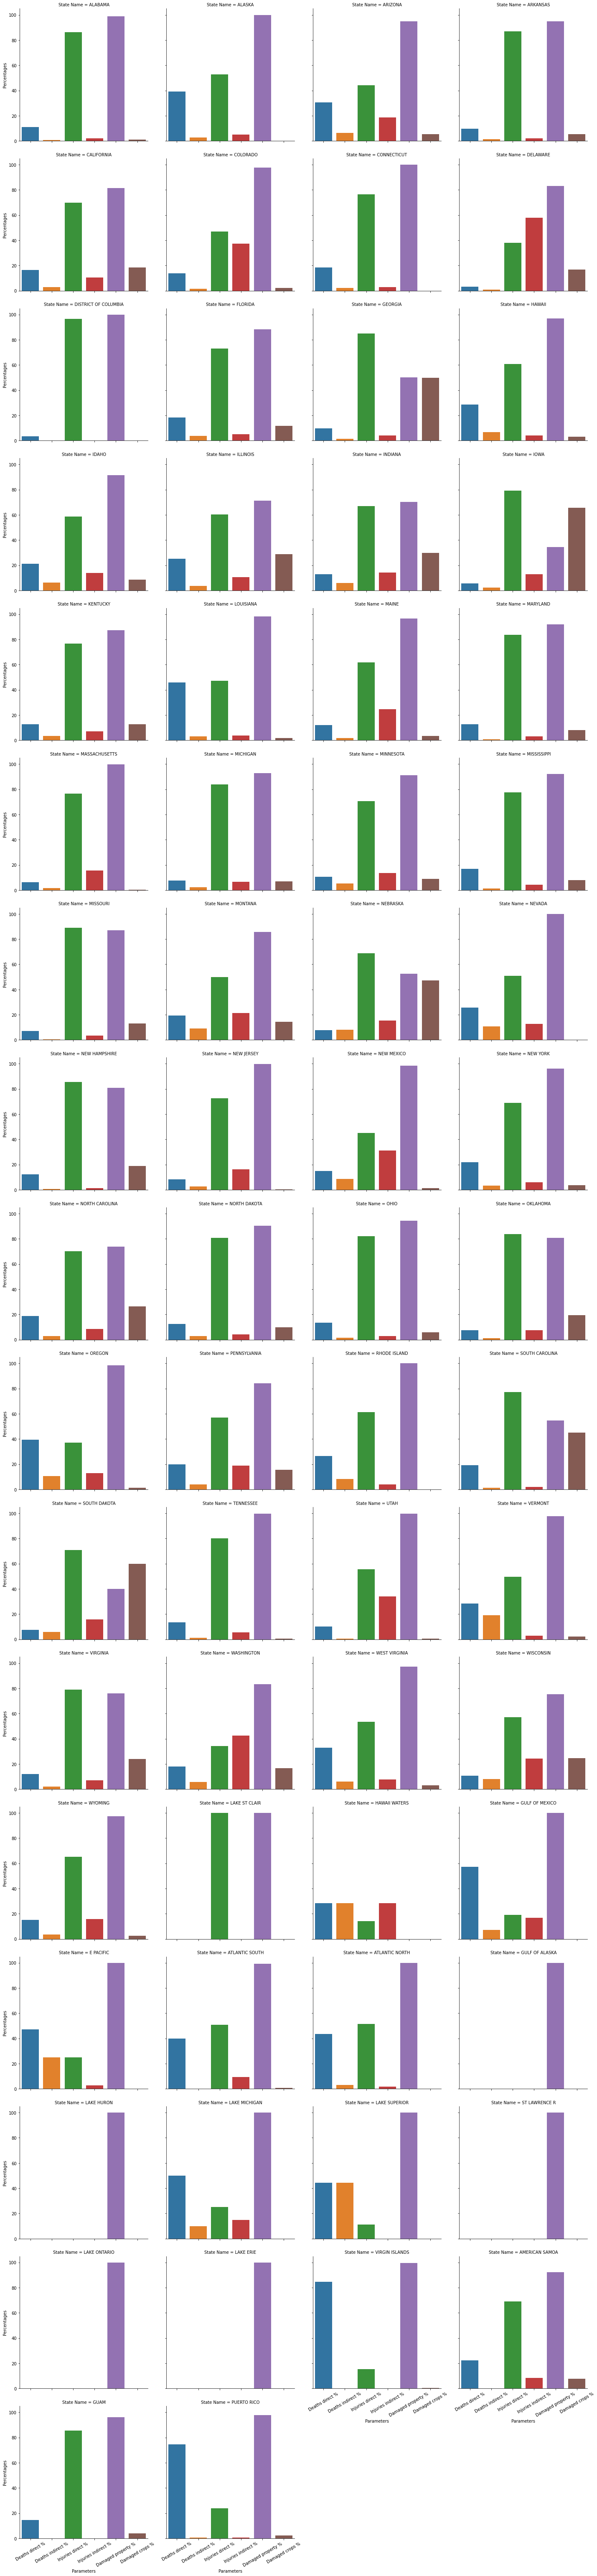

In [14]:
g = sns.catplot(x='Parameters', y='Percentages', data=correlation_percentage_of_all_states, kind='bar', col='State Name', col_wrap=4)
g.set_xticklabels(rotation=30)

In [54]:
#Seeing correlation of deaths/fatalities: This is an algorithm for generating the data if the user decides to see the breakdown of data as a summary
correlation_current_state = correlation_percentage_of_all_states.loc[correlation_percentage_of_all_states['State Name'] == 'OHIO']

In [4]:
#This is an algorithm for generating the data for the visual goal 'Seeing correlation between states and property damage/fatalities/injuries'. data generated from the algorithm below is used if the user decides to see the breakdown of data as a summary (i.e.:Answers 'no' to  question 'Would you like to see the breakdown of data in detail?')
correlation_percentage_average_states = pd.DataFrame()
correlation_percentage_average_states['Parameters'] = ['Deaths direct %', 'Deaths indirect %', 'Injuries direct %', 'Injuries indirect %', 'Damaged property %', 'Damaged crops %']

all_states_sum_of_injuries_deaths_indirect_direct = 0
all_states_sum_of_damaged_property_crops = 0
all_states_sum_deaths_direct = 0
all_states_sum_deaths_indirect = 0
all_states_sum_injuries_direct = 0
all_states_sum_injuries_indirect = 0
all_states_sum_damaged_property = 0
all_states_sum_damaged_crops = 0

for fips in state_state_fips_df.index:
    current_state_name = state_state_fips_df['STATE'][fips]
    current_state_stats = pd.read_excel(current_state_name+'.xlsx', index_col=0, sheet_name='Yearly data')
    all_states_sum_of_injuries_deaths_indirect_direct += sum(current_state_stats['states_total_injuries_direct'] + current_state_stats['states_total_injuries_indirect'] + current_state_stats['states_total_deaths_direct'] + current_state_stats['states_total_deaths_indirect'])
    all_states_sum_of_damaged_property_crops += sum(current_state_stats['states_total_damaged_property'] + current_state_stats['states_total_damaged_crops'])

    all_states_sum_deaths_direct += sum(current_state_stats['states_total_deaths_direct'])
    all_states_sum_deaths_indirect += sum(current_state_stats['states_total_deaths_indirect'])
    all_states_sum_injuries_direct += sum(current_state_stats['states_total_injuries_direct'])
    all_states_sum_injuries_indirect += sum(current_state_stats['states_total_injuries_indirect'])
    all_states_sum_damaged_property += sum(current_state_stats['states_total_damaged_property'])
    all_states_sum_damaged_crops += sum(current_state_stats['states_total_damaged_crops'])
correlation_percentage_average_states['Percentages'] = [
    (all_states_sum_deaths_direct/all_states_sum_of_injuries_deaths_indirect_direct)*100,
    (all_states_sum_deaths_indirect/all_states_sum_of_injuries_deaths_indirect_direct)*100,
    (all_states_sum_injuries_direct/all_states_sum_of_injuries_deaths_indirect_direct)*100,
    (all_states_sum_injuries_indirect/all_states_sum_of_injuries_deaths_indirect_direct)*100,
    (all_states_sum_damaged_property/all_states_sum_of_damaged_property_crops)*100,
    (all_states_sum_damaged_crops/all_states_sum_of_damaged_property_crops)*100
]
correlation_percentage_average_states['State Name'] = 'All states'
correlation_current_state = correlation_percentage_of_all_states.loc[correlation_percentage_of_all_states['State Name'] == 'OHIO']
correlation_percentage_as_summary = pd.concat([correlation_current_state, correlation_percentage_average_states], axis=0)

In [5]:
# sns
correlation_percentage_average_states

,Parameters,Percentages,State Name
0,Deaths direct %,14.830335,All states
1,Deaths indirect %,2.767424,All states
2,Injuries direct %,72.212647,All states
3,Injuries indirect %,10.189594,All states
4,Damaged property %,88.660830,All states
5,Damaged crops %,11.339170,All states


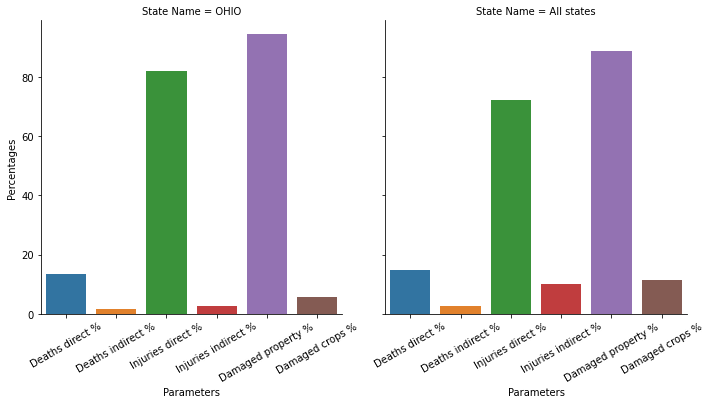

In [13]:
g = sns.catplot(x='Parameters', y='Percentages', data=correlation_percentage_as_summary, kind='bar', col='State Name')
g.set_xticklabels(rotation=30)

In [12]:
with pd.ExcelWriter('correlation_averages.xlsx') as writer:
    correlation_percentage_of_all_states.to_excel(writer, sheet_name='Correlation averages in detail')
    correlation_percentage_average_states.to_excel(writer, sheet_name='Correlation averages in Summary')